In [1]:
from os import getcwd
import json 
import pinocchio as pin
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import seaborn as sns

In [2]:
wd = getcwd()

file1_path = wd + '/results/scene1.json'

with open(file1_path, 'r') as file:
    data = json.load(file)

In [3]:
q_dist = [x[:7] for x in data['xs_dist']]
v_dist = [x[7:] for x in data['xs_dist']]

q_vel = [x[:7] for x in data['xs_vel']]
v_vel = [x[7:] for x in data['xs_vel']]

q_nocol = [x[:7] for x in data['xs_nocol']]
v_nocol = [x[7:] for x in data['xs_nocol']]

In [4]:
import pinocchio as pin
import numpy as np
import hppfcl
from numpy import r_
from wrapper_panda import PandaWrapper
np.set_printoptions(precision=4, linewidth=350, suppress=True, threshold=1e6)
import yaml

# Load variables from the YAML file
with open("config_scenes.yaml", "r") as file:
    config = yaml.safe_load(file)

# Access the 'scene' data
scene = config["scene1"]

#### Creating the robot
robot_wrapper = PandaWrapper()
rmodel, gmodel, vmodel = robot_wrapper()

gmodel.removeGeometryObject("panda1_box_0")
vmodel.removeGeometryObject("panda1_box_0")

radii1 = scene["DIM_OBS"][0]
radii2 = scene["DIM_ROB"][0]


Mobs = pin.SE3(
    pin.utils.rotate("y", np.pi) @ pin.utils.rotate("z", np.pi / 2),
    np.array([0, 0.1, 1.2]),
)
rmodel.addFrame(pin.Frame("obstacle", 0, 0, Mobs, pin.OP_FRAME))

idf1 = rmodel.getFrameId("obstacle")
idj1 = rmodel.frames[idf1].parentJoint
elips1 = hppfcl.Ellipsoid(*radii1)
elips1_geom = pin.GeometryObject(
    "el1", idj1, idf1, rmodel.frames[idf1].placement, elips1
)
elips1_geom.meshColor = r_[1, 0, 0, 1]
idg1 = gmodel.addGeometryObject(elips1_geom)

idf2 = rmodel.getFrameId("panda2_hand_tcp")
idj2 = rmodel.frames[idf2].parentJoint
elips2 = hppfcl.Ellipsoid(*radii2)
elips2_geom = pin.GeometryObject(
    "el2", idj2, idf2, rmodel.frames[idf2].placement, elips2
)
elips2_geom.meshColor = r_[1, 1, 0, 1]
idg2 = gmodel.addGeometryObject(elips2_geom)

rdata, gdata = rmodel.createData(), gmodel.createData()

In [5]:
def distance_to_obs(q):
        
    pin.forwardKinematics(rmodel, rdata, np.array(q))
    pin.updateFramePlacements(rmodel, rdata)
    pin.updateGeometryPlacements(rmodel, rdata, gmodel, gdata)
    obs_placement = gdata.oMg[idg1]
    rob_placement = gdata.oMg[idg2]
    
    req = hppfcl.DistanceRequest()
    res = hppfcl.DistanceResult()
    
    distance = hppfcl.distance(elips1, obs_placement,elips2, rob_placement, req, res)
    
    return distance    
    

In [6]:
dist__dist = []
dist_vel = []
dist_nocol = []

for q in q_dist:
    dist__dist.append(distance_to_obs(q))
for q in q_vel:
    dist_vel.append(distance_to_obs(q))
for q in q_nocol:
    dist_nocol.append(distance_to_obs(q))
    

Text(0.5, 0, 'Time step')

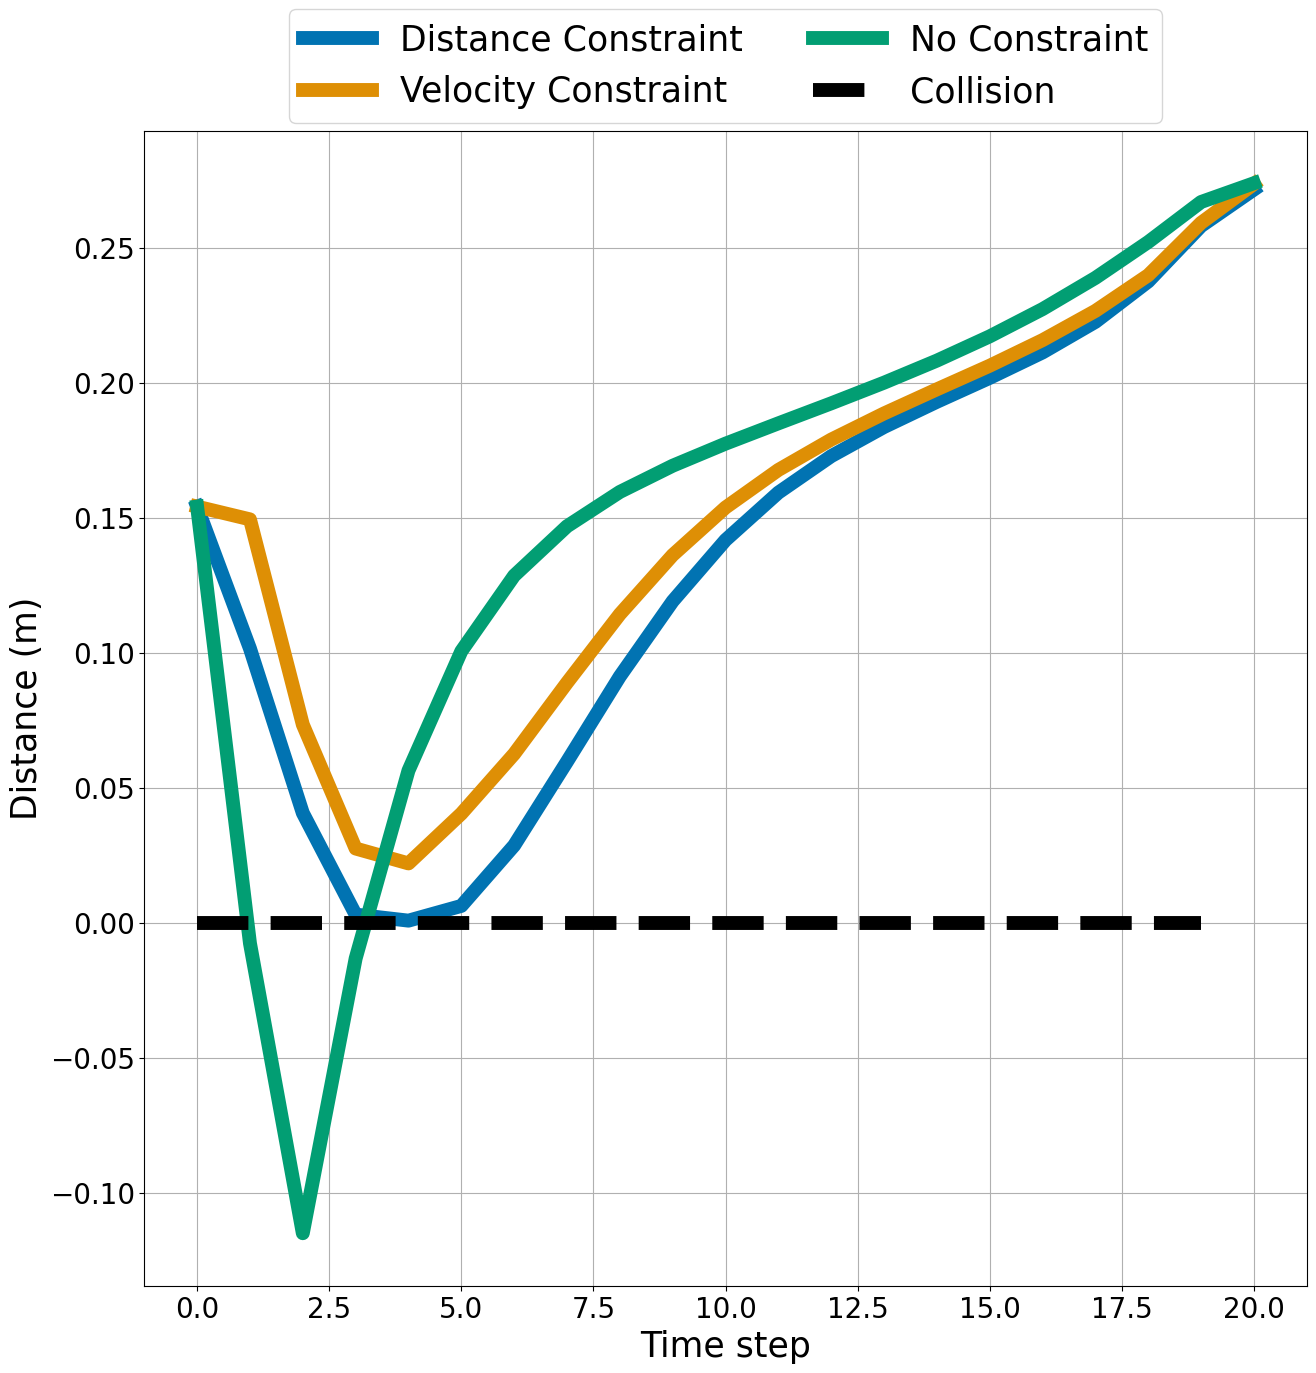

In [7]:
# Plot the distance to the obstacle of the end effector
# Set colorblind color palette
sns.set_palette("colorblind")
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 
plt.figure(figsize=(15, 15))
# Plot the distance to the obstacle of the end effector
plt.plot(dist__dist, linewidth=10, label='Distance Constraint')
plt.plot(dist_vel,linewidth=10,  label='Velocity Constraint')
plt.plot(dist_nocol,linewidth=10,  label='No Constraint')
plt.plot(np.zeros(scene["T"]), 'k--',linewidth=10, label='Collision')
plt.ylabel('Distance (m)', fontsize=25)
plt.grid()

plt.legend()
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=2
           ,fontsize=25)
plt.xlabel('Time step', fontsize=25)
